### Matrix Chain

```c++
void foo(){
    // (AB)C
    dgemm(A,B,200x200,200x500,B) ---> Qa_1,Qa_2,Qa_3
    dgemm(B,C,200x500,500x100,D) ---> Qb_1,Qb_2,Qb_3
} ---> Qfoo_1, Qfoo_2, Qfoo_3
```

time(foo) : $(\mathbf{Qa} , \mathbf{Qb},...) \to^{M.L}\to \mathbf{Qfoo}$

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.rcParams["figure.figsize"] = (20,10)

In [4]:
sizes = np.arange(100,1100,100)

In [7]:
tf.keras.backend.set_floatx('float64')

class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.d1 = tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.00), input_shape=(None,3))
    self.d2 = tf.keras.layers.Dense(128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.00))
    self.d3 = tf.keras.layers.Dense(64, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.00))
    self.d4 = tf.keras.layers.Dense(3, activation='linear', kernel_regularizer=tf.keras.regularizers.l2(0.00))

  def call(self, x):
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    return self.d4(x)

# Create an instance of the model
model = MyModel()

### Load Model and Check

In [8]:
model.load_weights('./checkpoints/chp_gemm_mnk')

In [65]:
eval_size = [100,100,100]
inp = tf.constant(eval_size,shape=(1,3),dtype="float64")
out = model(inp)

In [66]:
out

<tf.Tensor: id=420158, shape=(1, 3), dtype=float64, numpy=array([[-1.52185417, -0.41032617,  0.61338989]])>

### Model estimation

In [ ]:
sizes = np.arange(100,1100,100)

perfs_std = 20.44765391998221
perfs_mean  = 87.79658425316

x2 = []
y2 = []

for t_m in sizes:
    for t_n in sizes:
        for t_k in sizes:
            for t_l in sizes:
                x2.append(float(2*t_m*t_n*t_k + 2*t_m*t_k*t_l)/(t_m*t_n + t_n*t_k + 2*t_m*t_k + t_k*t_l + t_m*t_l))
                
                inp1 = [float(t_m),float(t_n),float(t_k)]
                inp1 = tf.constant(inp1,shape=(1,3),dtype="float64")
                out1 = (model(inp1).numpy()).reshape(-1)
                out1 = out1*perfs_std + perfs_mean
                t1 = float(2*t_m*t_n*t_k)*1e-9/out1
                
                inp2 = [float(t_m),float(t_k),float(t_l)]
                inp2 = tf.constant(inp2,shape=(1,3),dtype="float64")
                out2 = (model(inp2).numpy()).reshape(-1)
                out2 = out2*perfs_std + perfs_mean
                t2 = float(2*t_m*t_k*t_l)*1e-9/out2
                
                y2.append(t1+t2)
                
y2 = np.array(y2)

In [16]:
y2 = np.array(y2)

In [18]:
y2.shape

(10000, 3)

### Ground Truth

In [27]:
filename = "data/matchain_mnkl.txt"

In [57]:
with open(filename) as f:
    lines = f.readlines()
    x = []
    
    y_time_1 = []
    y_time_2 = []
    y_time_3 = []
    
    y_perf = []
    
    c = 0
    vc = []
    
    for line in lines:
        c = c+1
        time = float(line.split()[4])
        vc.append(time)
        
        if c == 20:
            
            m = float(line.split()[0])
            n = float(line.split()[1])
            k = float(line.split()[2])
            l = float(line.split()[3])
            time = float(line.split()[4])
            flops = float(line.split()[5])

            mem_ref = m*n + n*k + m*k + m*k + k*l + m*l 
            flop_bytes = flops/mem_ref
            x.append(flop_bytes)
            #x.append(flop_bytes)
            #x.append(flop_bytes)
            
            y_time_1.append(vc[int(0.15*20)])
            y_time_2.append(vc[int(0.5*20)])
            y_time_3.append(vc[int(0.85*20)])
            
            c = 0
            vc = []
            
        #x.append(m) 
        #y_perf.append((flops/time)*1e-9)

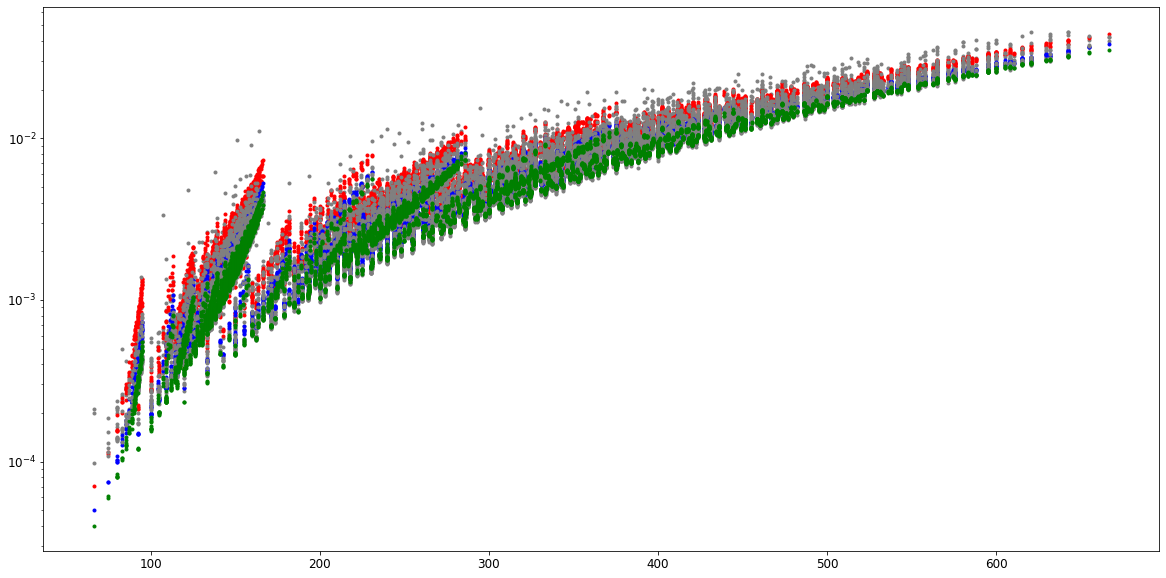

In [123]:
plt.yscale('log')
#plt.xlim(400,410)
plt.plot(x,y_time_1,'.',color='grey')
plt.plot(x2,y2[:,0],'.',color='r')
plt.plot(x,y_time_2,'.',color='grey')
plt.plot(x2,y2[:,1],'.',color='b')
plt.plot(x,y_time_3,'.',color='grey')
plt.plot(x2,y2[:,2],'.',color='g')
plt.show()

In [45]:
len(x2)

10000

In [62]:
len(x)

10000

### Deploy methods

In [77]:
def get_gt(M,N,K,L):
    filename = "data/matchain_mnkl.txt"
    with open(filename) as f:
        lines = f.readlines()
        y = []
        for line in lines:

            m = float(line.split()[0])
            n = float(line.split()[1])
            k = float(line.split()[2])
            l = float(line.split()[3])

            if (m==M and n==N and k==K and l==L):
                y.append(float(line.split()[4]))  

    y.sort()
    return y

In [75]:
def estimate_gemm(m,n,k):
    perfs_std = 20.44765391998221
    perfs_mean  = 87.79658425316

    eval_size = [m,n,k]
    inp = tf.constant(eval_size,shape=(1,3),dtype="float64")
    out = model(inp)
    out = out*perfs_std + perfs_mean
    t = float(2*m*n*k)*1e-9/out
    return t.numpy()

def estimate_matchain(m,n,k,l):
    t1 = estimate_gemm(m,n,k)
    t2 = estimate_gemm(m,k,l)
    t = t1+t2
    x_p = float(2*m*n*k + 2*m*k*l)/(m*n + n*k + 2*m*k + k*l + m*l)
    return (t,x_p)

### Evaluation

$(AB)C \qquad A \in \mathbb{R}^{m \times n} \quad B \in \mathbb{R}^{n \times k} \quad C \in \mathbb{R}^{k \times l}$ 

In [140]:
M=910
N=202
K=102
L=902
estimate_matchain(M,N,K,L)

(array([[0.003169  , 0.00228849, 0.001962  ]]), 157.30174811649198)

In [139]:
M=900
N=200
K=100
L=900
get_gt(M,N,K,L)

[0.0017884,
 0.0018162,
 0.0018627000000000001,
 0.0018813,
 0.0018818,
 0.0019668000000000003,
 0.0019755000000000003,
 0.002006,
 0.0020107000000000002,
 0.0020217,
 0.0020301,
 0.0021568,
 0.0021826000000000003,
 0.0022219,
 0.0022824,
 0.0023586,
 0.0026239,
 0.0033024,
 0.0033236000000000003,
 0.0033244000000000004]